In [67]:
# Import Libraries
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense
from keras.utils import set_random_seed
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Set default figure size for matplotlib plots
plt.rcParams['figure.figsize'] = [6, 6]

## Johnson & Johnson

In [27]:
# Load Johnson and Johnson data
jj_data = pd.read_csv('jj.csv')
jj_data

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


In [28]:
jj_data['data'].info

<bound method Series.info of 0      0.71
1      0.63
2      0.85
3      0.44
4      0.61
      ...  
79     9.99
80    16.20
81    14.67
82    16.02
83    11.61
Name: data, Length: 84, dtype: float64>

In [29]:
jj_data.isnull().sum()

date    0
data    0
dtype: int64

### Graph for J&J

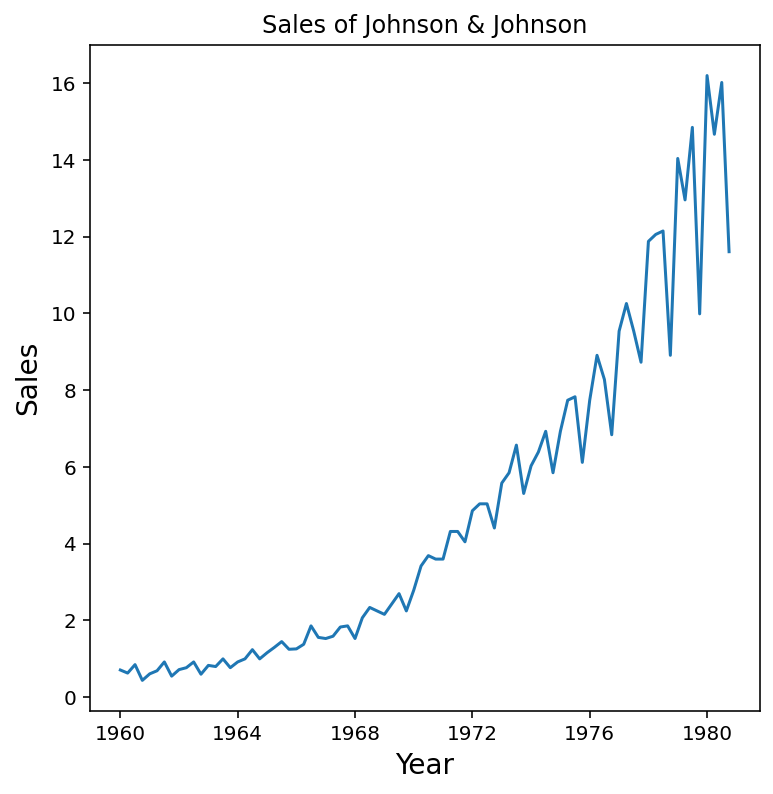

In [72]:
# Plot for johnson and johnson data 
fig, ax = plt.subplots(dpi=144)
plt.plot(jj_data['data'])
plt.title('Sales of Johnson & Johnson')
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.show()

## Stationarity

### ACF and PACF

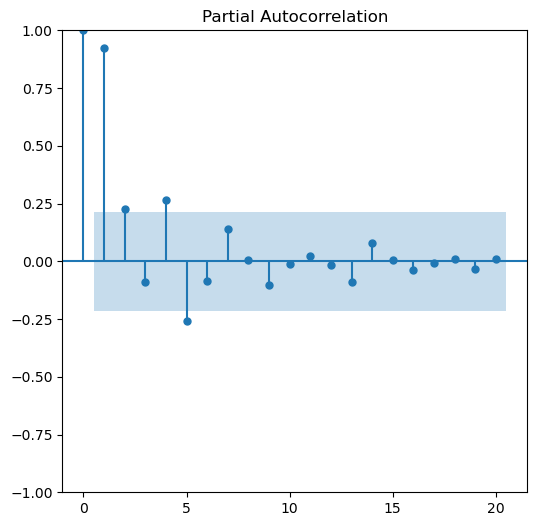

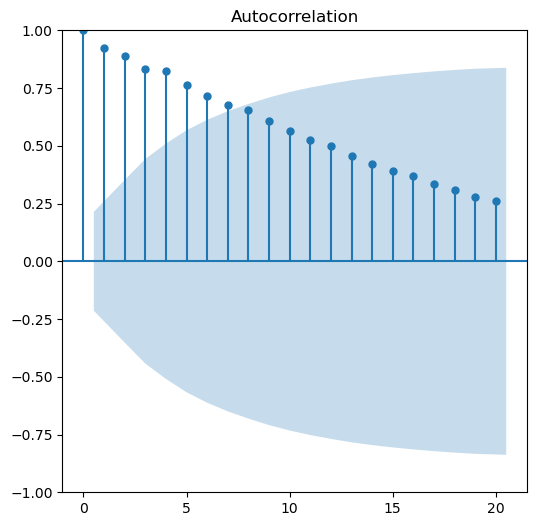

In [7]:
# plot the ACF and PACF for Johnson and Johnson
plot_pacf(jj_data['data']);
plot_acf(jj_data['data']);
plt.show()

### ADF Test for stationarity

In [8]:
# ADF Test for J&J data 
ad_fuller_result = adfuller(jj_data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457468
p-value: 1.0


J&J data is non-stationary. So we need to make data stationary.

### J&J data made Stationary using Log Transform

In [9]:
# take the log()
jj_data['data_log'] = np.log(jj_data['data'])
# then take the first difference
jj_data['data_tr'] = jj_data['data_log'].diff()
jj_data.head()

,date,data,data_log,data_tr
0,1960-01-01,0.71,-0.342490,NaN
1,1960-04-01,0.63,-0.462035,-0.119545
2,1960-07-02,0.85,-0.162519,0.299517
3,1960-10-01,0.44,-0.820981,-0.658462
4,1961-01-01,0.61,-0.494296,0.326684


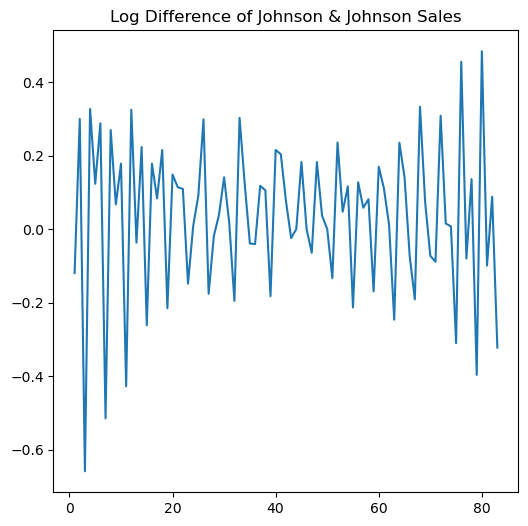

In [10]:
plt.plot(jj_data['data_tr'])
plt.title("Log Difference of Johnson & Johnson Sales")
plt.show()

In [11]:
#adf test to check for stationarity

ad_fuller_result = adfuller(jj_data['data_tr'][1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811842
p-value: 0.00041497314044405755


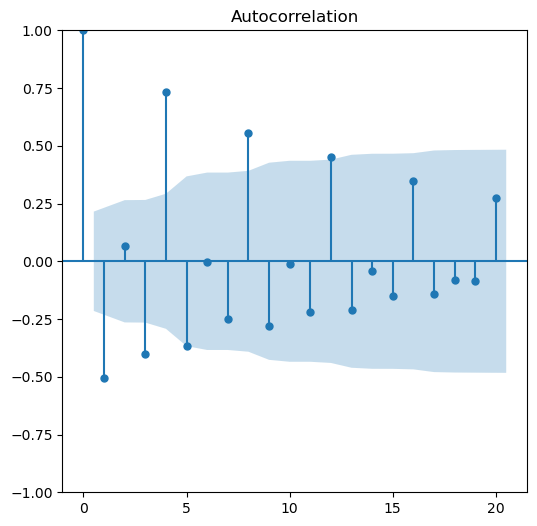

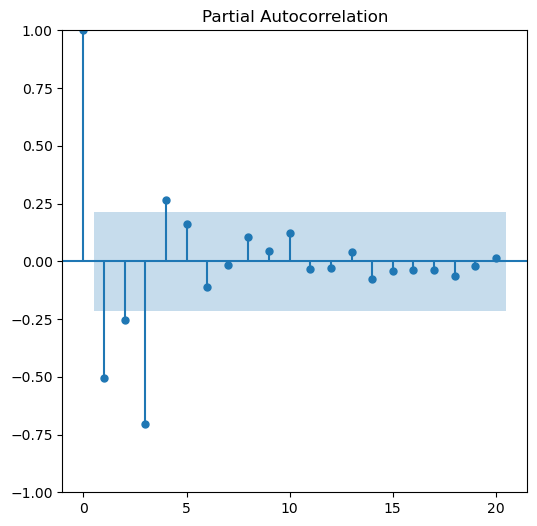

In [12]:
plot_acf(jj_data['data_tr'][1:]);
plot_pacf(jj_data['data_tr'][1:]);
plt.show()

### ARIMA Model on J&J

In [13]:
# define model
jj_model = ARIMA(jj_data['data'], order=(3,1,3))

In [14]:
# record the best model fit in a parameter 
jj_model_fit = jj_model.fit()

In [15]:
print(jj_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -76.286
Date:                Wed, 09 Apr 2025   AIC                            166.572
Time:                        15:34:00   BIC                            183.504
Sample:                             0   HQIC                           173.374
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0311      0.036    -28.913      0.000      -1.101      -0.961
ar.L2         -1.0273      0.043    -23.887      0.000      -1.112      -0.943
ar.L3         -0.9768      0.030    -32.166      0.0

In [16]:
# Function to find the best p,d,q values for the model
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p, d, q) tuples
        endog - the observed variable, in this case data['data']
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            #model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
        except:
            continue
            
        aic = model_fit.aic
        results.append([order, model_fit.aic])
        #print(order)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
# define the order list
ps = range(0, 8, 1)
d = 0
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

In [18]:
# call opitimize_ARIMA
jj_result = optimize_ARIMA(jj_data['data'], order_list)


# print out the ordered list. The best model fit (lowest AIC) will be shown at the top
jj_result

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.735928
1,"(4, 1, 6)",115.859253
2,"(7, 1, 1)",116.061742
3,"(5, 1, 3)",116.536230
4,"(5, 1, 4)",117.242502
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [19]:
# re-define the best fit model variant.
# p,d,q ARIMA Model
jj_best_model = ARIMA(jj_data['data'], order=(6,1,3))

jj_best_model_fit = jj_best_model.fit()

In [20]:
#summary of the jj model
print(jj_best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.868
Date:                Wed, 09 Apr 2025   AIC                            115.736
Time:                        15:34:25   BIC                            139.924
Sample:                             0   HQIC                           125.453
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4910      0.132    -11.279      0.000      -1.750      -1.232
ar.L2         -0.7853      0.151     -5.187      0.000      -1.082      -0.489
ar.L3          0.0377      0.061      0.614      0.5

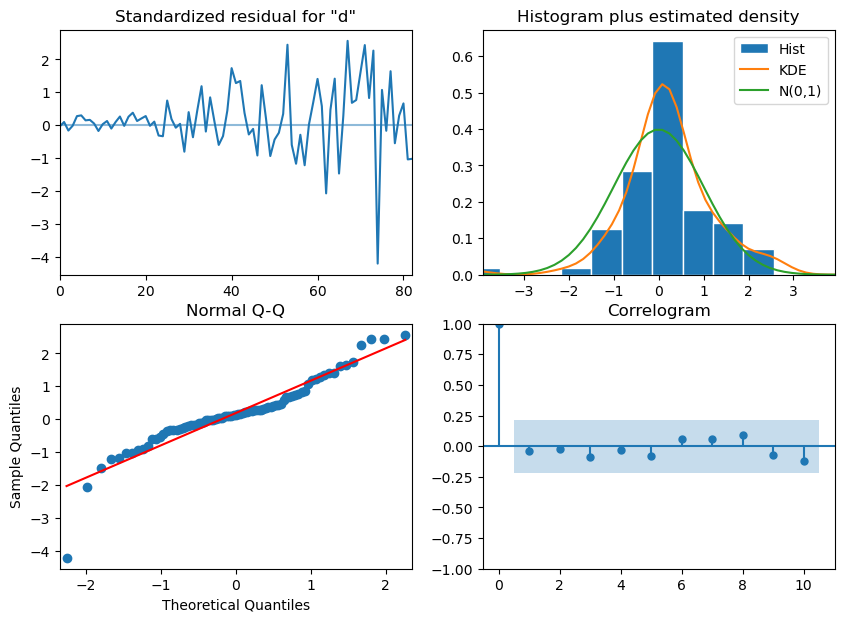

In [21]:
# plot the model diagnostics
jj_best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [22]:
#get prediction start and end dates of jj_data
jj_test_data = jj_data['data']

pred_start_date = jj_test_data.index[0]
pred_end_date = jj_test_data.index[-1]

#get the predictions and residuals
jj_predictions = jj_best_model_fit.predict(start=pred_start_date, end=pred_end_date)
jj_residuals = jj_test_data - jj_predictions

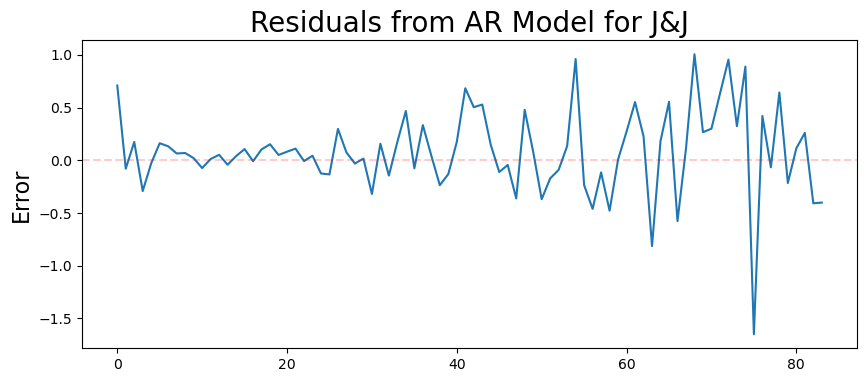

In [23]:
# plot the residuals of jj_data
plt.figure(figsize=(10,4))
plt.plot(jj_residuals)
plt.title('Residuals from AR Model for J&J', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [24]:
# Assess the root mean square of the residuals
print('RMSE:', np.sqrt(np.mean(jj_residuals**2)))

RMSE: 0.4006208229655024


Text(0.5, 0, 'Month Number')

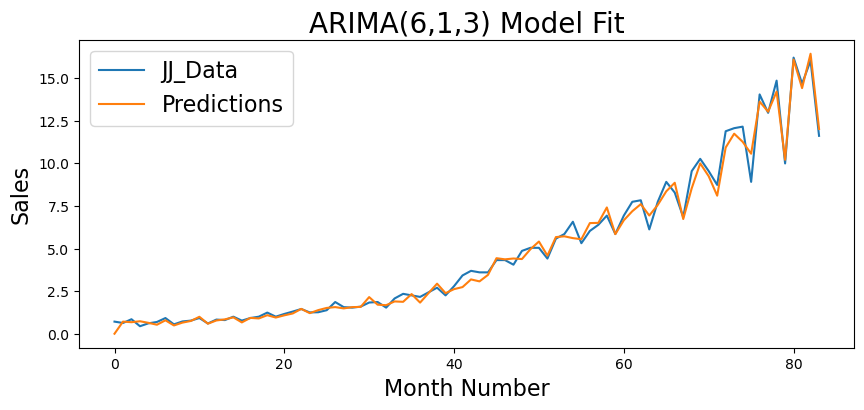

In [25]:
# Plot the model prediction against the data
plt.figure(figsize=(10,4))
plt.plot(jj_test_data)
plt.plot(jj_predictions)
plt.legend(('JJ_Data', 'Predictions'), fontsize=16)
plt.title('ARIMA(6,1,3) Model Fit', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Month Number', fontsize=16)

In [26]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(jj_predictions, jj_test_data)

{'mape': 0.08960196449126984,
 'me': -0.08056933532783592,
 'mae': 0.27823570046689783,
 'mpe': -0.028059464689499942,
 'rmse': 0.4006208229655024,
 'corr': 0.9958012705869131,
 'minmax': 0.08446756101418784}

### Forcast the J&J sales for 24 months

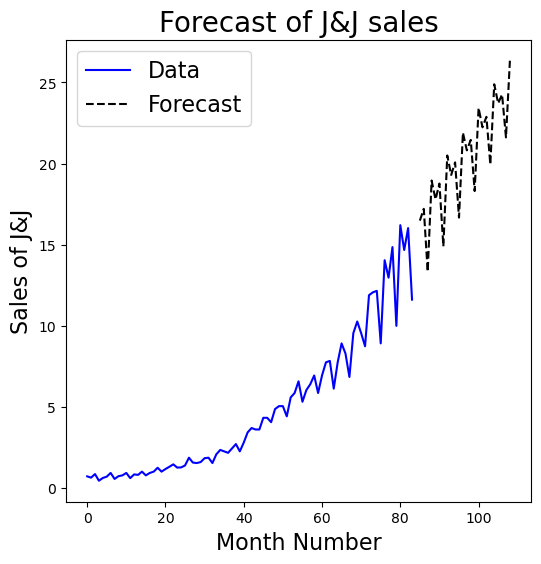

In [27]:
# 24 months
n_forecast = 24 

jj_predict = jj_best_model_fit.get_prediction(end=jj_model.nobs + n_forecast)
# get an index to plot the forecast from the end of real data
jj_idx = np.arange(len(jj_predict.predicted_mean)) 

# plot
fig, ax = plt.subplots()
ax.plot(jj_data['data'], 'blue') # plots original data
ax.plot(jj_idx[-n_forecast:], jj_predict.predicted_mean[-n_forecast:], 'k--') #plots forecast
plt.ylabel('Sales of J&J', fontsize=16)
plt.xlabel('Month Number', fontsize=16)
plt.title('Forecast of J&J sales', fontsize=20)
plt.legend(('Data', 'Forecast'), fontsize=16)
plt.show()

In [28]:
# use get_forecast() for getting the predicted values
# make the predictions for 24 steps ahead
jj_predictions_int = jj_best_model_fit.get_forecast(steps=24)
jj_predictions_int.predicted_mean

84     17.344399
85     16.482277
86     17.208350
87     13.335367
88     18.953278
89     17.791756
90     18.767431
91     14.895357
92     20.497667
93     19.297502
94     20.074250
95     16.667322
96     21.904126
97     20.814733
98     21.460094
99     18.304023
100    23.428591
101    22.235766
102    22.885077
103    19.948079
104    24.890703
105    23.717293
106    24.257850
107    21.612169
Name: predicted_mean, dtype: float64

In [29]:
# get a better view
jj_predictions_int.conf_int()

,lower data,upper data
84,16.575626,18.113172
85,15.694982,17.269572
86,16.352441,18.064259
87,12.478565,14.192170
88,17.549165,20.357391
89,16.363864,19.219648
90,17.235968,20.298894
91,13.332088,16.458626
92,18.529440,22.465894
93,17.254205,21.340799


In [30]:
# add the predicted mean column in the dataframe
jj_conf_df = pd.concat([jj_predictions_int.predicted_mean, jj_predictions_int.conf_int()], axis = 1)
jj_conf_df.head()

,predicted_mean,lower data,upper data
84,17.344399,16.575626,18.113172
85,16.482277,15.694982,17.269572
86,17.208350,16.352441,18.064259
87,13.335367,12.478565,14.192170
88,18.953278,17.549165,20.357391


In [31]:
# change the name of the column heads
jj_conf_df = jj_conf_df.rename(columns={'predicted_mean': 'Predictions', 'lower data': 'Lower CI', 'upper data': 'Upper CI'})
jj_conf_df.head()

,Predictions,Lower CI,Upper CI
84,17.344399,16.575626,18.113172
85,16.482277,15.694982,17.269572
86,17.208350,16.352441,18.064259
87,13.335367,12.478565,14.192170
88,18.953278,17.549165,20.357391


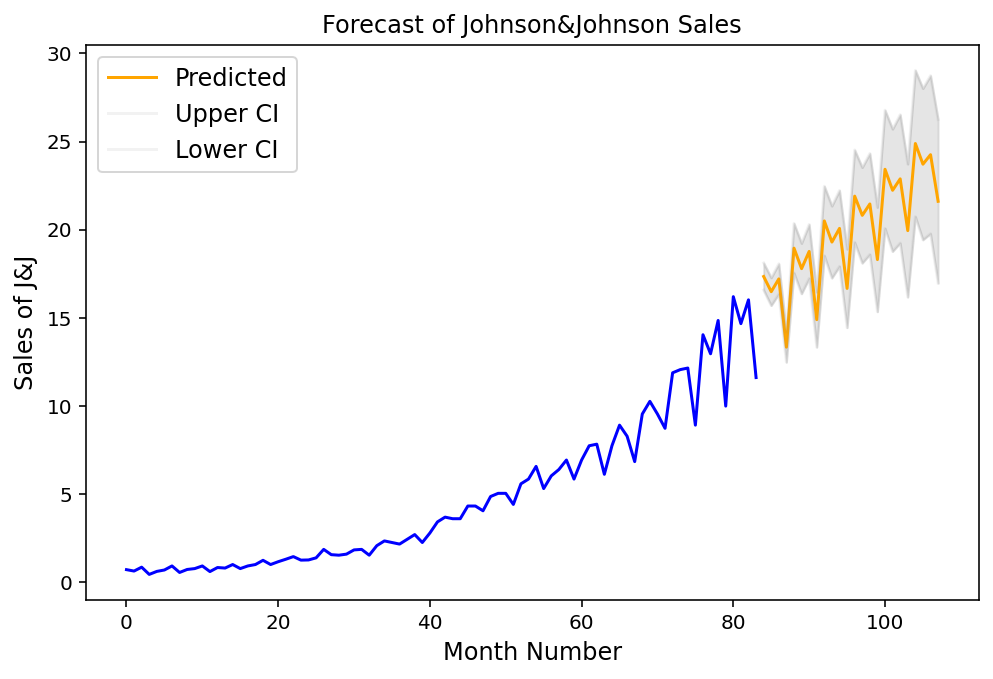

In [32]:
# make a plot of model fit
fig, ax = plt.subplots(figsize = (8,5), dpi=144)
ax.plot(jj_data['data'], 'b')
ax.set(title='Forecast of Johnson&Johnson Sales')
x = jj_conf_df.index.values
upper = jj_conf_df['Upper CI']
lower = jj_conf_df['Lower CI']
jj_conf_df['Predictions'].plot(color = 'orange',label = 'Predicted' )
upper.plot(color = 'grey', label = 'Upper CI', alpha=0.1)
lower.plot(color = 'grey', label = 'Lower CI', alpha=0.1)
# fill between the conf intervals
ax.fill_between(x, lower, upper, color='grey', alpha=0.2)
plt.ylabel('Sales of J&J', fontsize=12)
plt.xlabel('Month Number', fontsize=12)
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

## Amazon Data

In [47]:
# Load Amazon data
amzn_data = pd.read_csv('AMZN.csv')
amzn_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [48]:
# covert the date column to datetime type and set it as index
amzn_data['Date']=pd.to_datetime(amzn_data['Date'])
amzn_data.set_index('Date',inplace=True)
amzn_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [35]:
amzn_data['Close'].info

<bound method Series.info of Date
2018-02-20     73.417503
2018-02-21     74.146004
2018-02-22     74.266998
2018-02-23     75.000000
2018-02-26     76.097504
                 ...    
2023-02-13     99.540001
2023-02-14     99.699997
2023-02-15    101.160004
2023-02-16     98.150002
2023-02-17     97.199997
Name: Close, Length: 1259, dtype: float64>

In [36]:
amzn_data['Close'].isnull().sum()

0

In [37]:
amzn_data.index

DatetimeIndex(['2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-05',
               ...
               '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09',
               '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15',
               '2023-02-16', '2023-02-17'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

### Graph the Amazon data

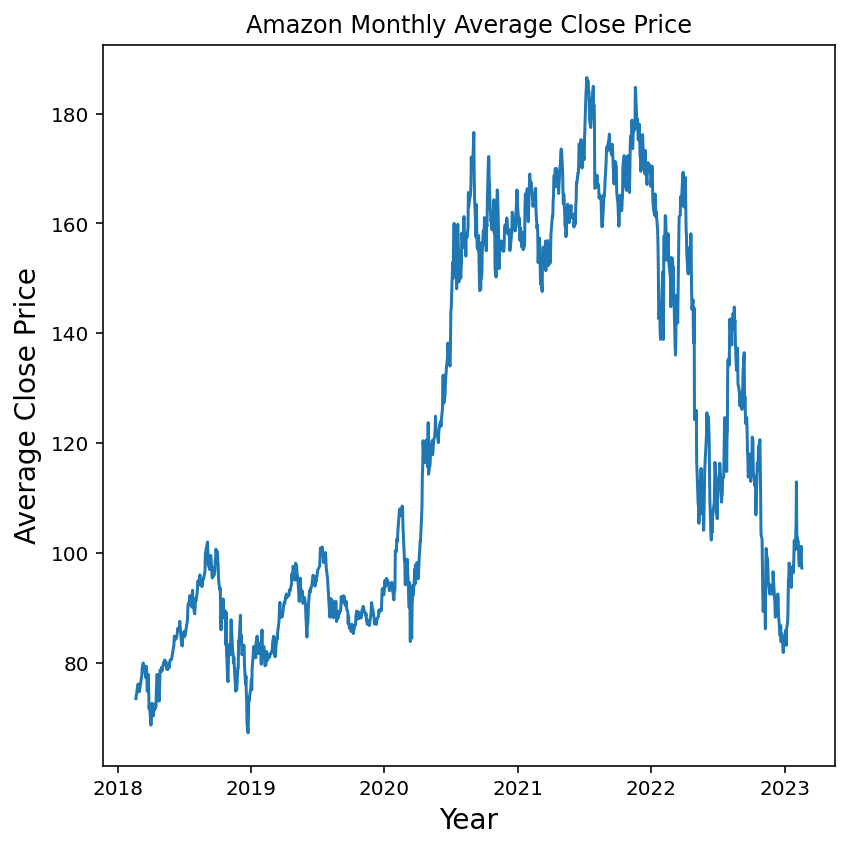

In [71]:
# Plot
fig, ax = plt.subplots(dpi=144)
plt.plot(amzn_data['Close'])
plt.title('Amazon Monthly Average Close Price')
plt.xlabel('Year',fontsize=14)
plt.ylabel('Average Close Price',fontsize=14)
plt.tight_layout()
plt.show()

## Stationarity

### ACF and PACF

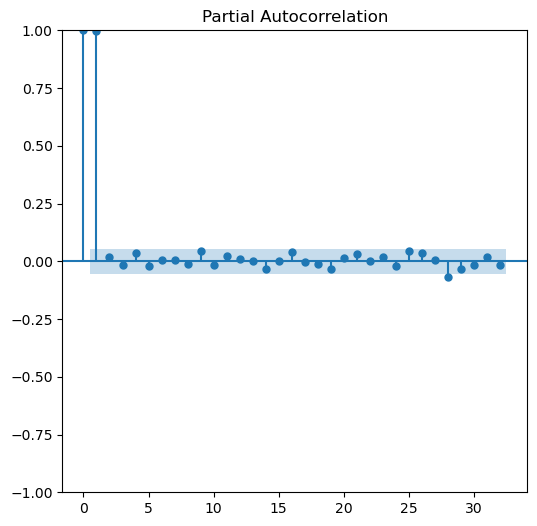

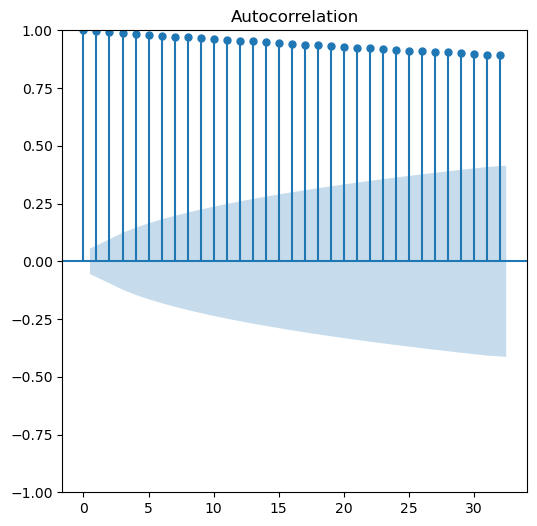

In [39]:
# plot the ACF and PACF for Amazon
plot_pacf(amzn_data['Close']);
plot_acf(amzn_data['Close']);
plt.show()

### ADF Test for stationarity

In [40]:
# ADF Test for Amazon data 
ad_fuller_result = adfuller(amzn_data['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.657808991333173
p-value: 0.45297105465166737


The data is non stationary. we need to make it stationary using Log transform.

In [41]:
# take the log()
amzn_data['data_log'] = np.log(amzn_data['Close'])
# then take the first difference
amzn_data['data_tr'] = amzn_data['data_log'].diff()
amzn_data.head()

,Open,High,Low,Close,Adj Close,Volume,data_log,data_tr
Date,,,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000,4.296162,NaN
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000,4.306036,0.009874
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000,4.307667,0.001631
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000,4.317488,0.009821
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000,4.332015,0.014527


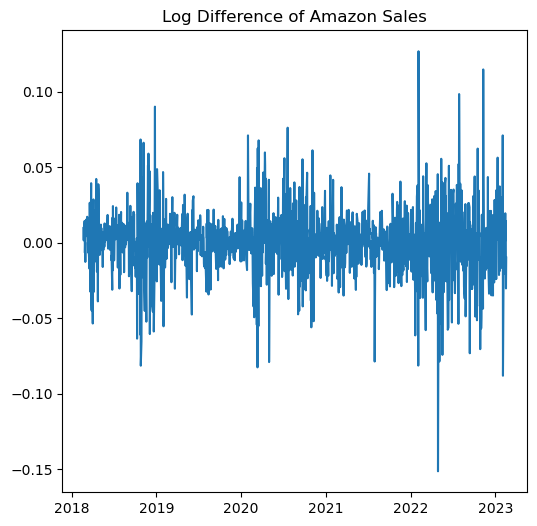

In [42]:
plt.plot(amzn_data['data_tr'])
plt.title("Log Difference of Amazon Sales")
plt.show()

In [43]:
ad_fuller_result = adfuller(amzn_data['data_tr'][1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -36.63983281274942
p-value: 0.0


### ARMA Model on Amazon data

In [44]:
#define model
amzn_model = ARIMA(amzn_data['Close'], order=(3,1,3))

# record the best model fit in a parameter 
amzn_model_fit = amzn_model.fit()

In [45]:
print(amzn_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3055.626
Date:                Wed, 09 Apr 2025   AIC                           6125.252
Time:                        15:34:30   BIC                           6161.213
Sample:                             0   HQIC                          6138.766
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7345      0.058    -12.629      0.000      -0.849      -0.621
ar.L2          0.6658      0.096      6.939      0.000       0.478       0.854
ar.L3          0.9193      0.056     16.354      0.0

In [46]:
# call opitimize_ARIMA
amzn_result_df = optimize_ARIMA(amzn_data['Close'], order_list)

# print out the ordered list. The best model fit (lowest AIC) will be shown at the top
amzn_result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(2, 1, 2)",6122.315476
1,"(3, 1, 2)",6124.039832
2,"(2, 1, 3)",6124.044467
3,"(3, 1, 3)",6125.251778
4,"(4, 1, 2)",6125.951759
...,...,...
59,"(0, 1, 7)",6138.374108
60,"(7, 1, 0)",6138.584491
61,"(4, 1, 7)",6138.639316
62,"(7, 1, 7)",6139.478185


In [47]:
# p,d,q ARIMA Model
amzn_best_model = ARIMA(amzn_data['Close'], order=(2,1,2))
amzn_best_model_fit = amzn_best_model.fit()

In [48]:
#summary of the model
print(amzn_best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3056.158
Date:                Wed, 09 Apr 2025   AIC                           6122.315
Time:                        15:35:57   BIC                           6148.002
Sample:                             0   HQIC                          6131.969
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6946      0.015   -111.814      0.000      -1.724      -1.665
ar.L2         -0.9604      0.015    -64.729      0.000      -0.989      -0.931
ma.L1          1.6972      0.011    152.239      0.0

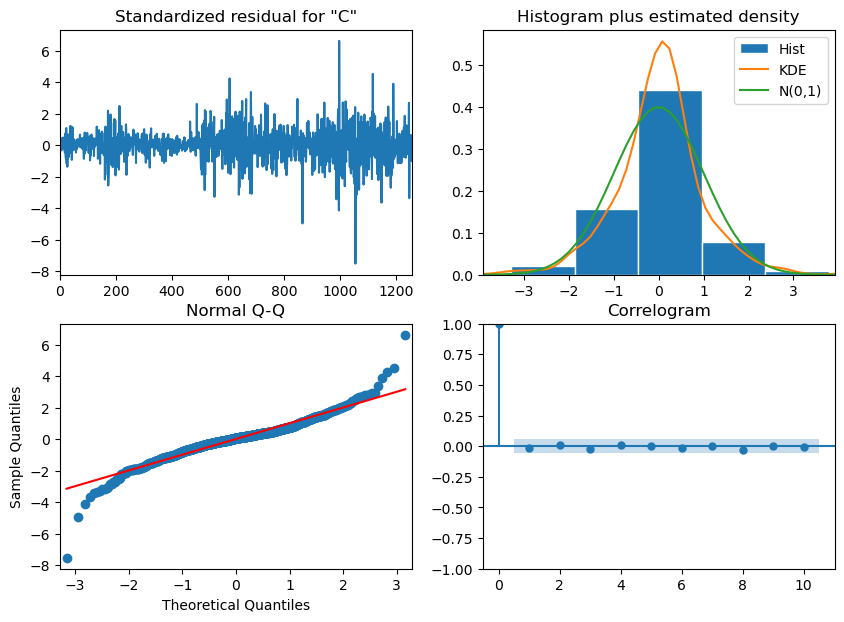

In [49]:
amzn_best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [50]:
#get prediction start and end dates
amzn_test_data = amzn_data['Close']

pred_start_date = amzn_test_data.index[0]
pred_end_date = amzn_test_data.index[-1]

#get the predictions and residuals
amzn_predictions = amzn_best_model_fit.predict(start=pred_start_date, end=pred_end_date)
amzn_residuals = amzn_test_data - amzn_predictions

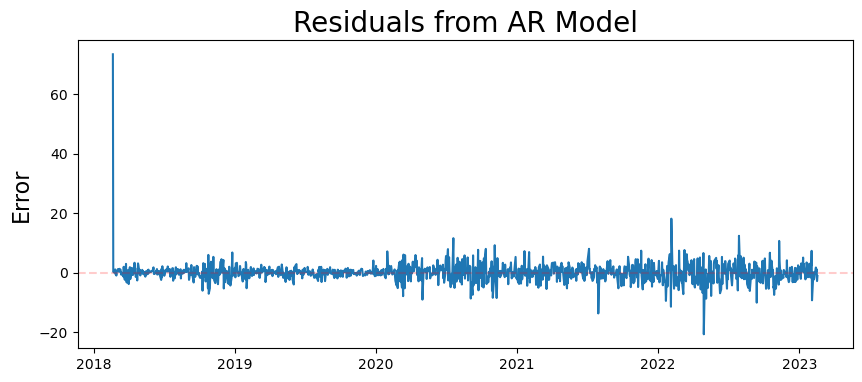

In [51]:
# plot the residuals
plt.figure(figsize=(10,4))
plt.plot(amzn_residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [52]:
# Assess the root mean square of the residuals
print('RMSE:', np.sqrt(np.mean(amzn_residuals**2)))

RMSE: 3.437714287175116


Text(0.5, 0, 'Year')

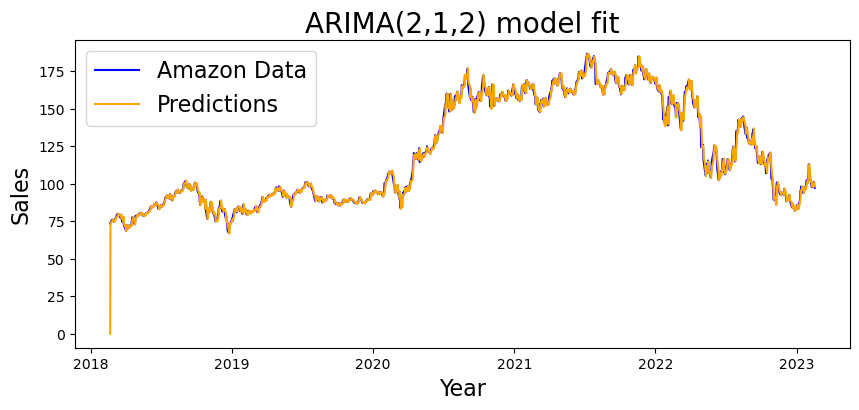

In [53]:
# Plot the model prediction against the data
plt.figure(figsize=(10,4))
plt.plot(amzn_test_data,color='blue')
plt.plot(amzn_predictions,color='orange')
plt.legend(('Amazon Data', 'Predictions'), fontsize=16)
plt.title('ARIMA(2,1,2) model fit', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Year', fontsize=16)

In [54]:
forecast_accuracy(amzn_predictions, amzn_test_data)

{'mape': 0.016931562175109802,
 'me': -0.07707837399287752,
 'mae': 1.9760997604844854,
 'mpe': -0.0007597541944668388,
 'rmse': 3.437714287175116,
 'corr': 0.9951401775635079,
 'minmax': 0.01666692323748875}

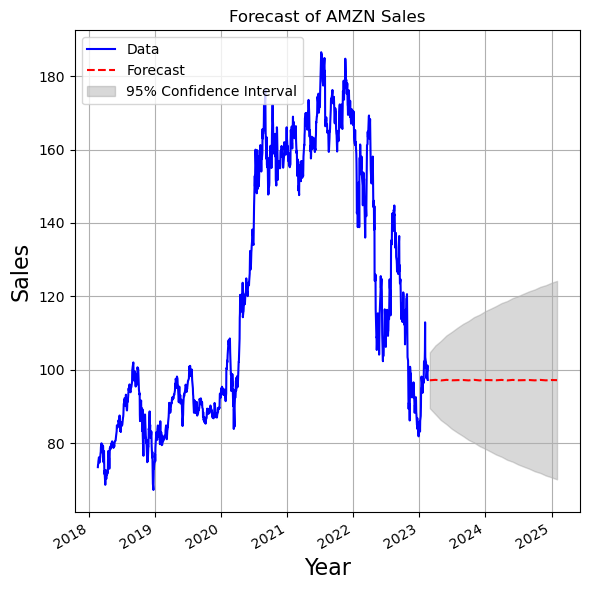

In [55]:
n_forecast = 24 #24 months
amzn_predict = amzn_best_model_fit.get_prediction(end=amzn_model.nobs + n_forecast)
# Get predicted mean (includes in-sample and forecast)
predicted_mean = amzn_predict.predicted_mean

forecast_conf_int = amzn_predict.conf_int()

# Create forecast index that starts after the last date in your original data
last_idx = amzn_data.index[-1]
forecast_index = pd.date_range(start=last_idx + pd.offsets.MonthEnd(1), periods=n_forecast, freq='M')

# Extract the lower and upper bounds from the forecast confidence interval
lower_bound = forecast_conf_int.iloc[:, 0]  # lower bound
upper_bound = forecast_conf_int.iloc[:, 1]  # upper bound

# plot
fig, ax = plt.subplots()
amzn_data['Close'].plot(ax=ax, label='Data', color='blue')

# Plot forecast (only last n_forecast points)
ax.plot(forecast_index, predicted_mean[-n_forecast:], 'k--', label='Forecast',color='red')

# # Plot confidence interval boundaries
ax.fill_between(forecast_index,
                lower_bound[-n_forecast:], upper_bound[-n_forecast:],
                color='grey',
                alpha=0.3,
                label='95% Confidence Interval')

# Labels and formatting
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Forecast of AMZN Sales')
plt.legend(fontsize=10,loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM

In [5]:
def transform_to_supervised(time_series_data, lookback=1):
    """
    Transforms time series data into a supervised learning format.
    Returns:
        pd.DataFrame: Transformed DataFrame.
    Args:
        time_series_data: List or array of time series data.
        lookback: Number of previous time steps to use as input features.
    """
    data = pd.DataFrame(time_series_data)
    past_columns = [data.shift(i) for i in range(1, lookback + 1)]
    present_column = [data]
    combined_columns = past_columns + present_column
    reshaped_frame = pd.concat(combined_columns, axis=1)
    reshaped_frame.fillna(0, inplace=True)
    return reshaped_frame

In [7]:
def normalize_data(training_data, testing_data):
    """
    Scales training and testing data to the range [-1, 1].
    Returns:
        tuple: A tuple containing the fitted scaler, scaled training data, and scaled testing data.
    Args:
        training_data: List or array of training data.
        testing_data: List or array of testing data.
    """
    # Initialize and fit the MinMaxScaler
    data_scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaler = data_scaler.fit(training_data)

    # Transform training data
    training_data_reshaped = training_data.reshape(training_data.shape[0], training_data.shape[1])
    training_data_normalized = data_scaler.transform(training_data_reshaped)

    # Transform testing data
    testing_data_reshaped = testing_data.reshape(testing_data.shape[0], testing_data.shape[1])
    testing_data_normalized = data_scaler.transform(testing_data_reshaped)
    return data_scaler, training_data_normalized, testing_data_normalized


In [15]:
def build_lstm_model(train_set, batch_size_val, epochs_val, num_neurons):
    """
    Builds and fits an LSTM network to the training data.
    Returns:
      tensorflow.keras.models.Sequential: The trained LSTM model.
    Args:
      train_set: The training data.
      batch_size_val: The batch size for training.
      epochs_val: The number of training epochs.
      num_neurons: The number of neurons in the LSTM layer.
    """
    input_x, output_y = train_set[:, 0:-1], train_set[:, -1]
    input_x_reshaped = input_x.reshape(input_x.shape[0], 1, input_x.shape[1])#(samples, time steps, features)
    lstm_model = Sequential()
    lstm_model.add(LSTM(num_neurons, activation='relu', input_shape=(input_x_reshaped.shape[1], input_x_reshaped.shape[2])))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    lstm_model.fit(input_x_reshaped, output_y, epochs=epochs_val, batch_size=batch_size_val, verbose=0, shuffle=False)
    return lstm_model



In [19]:
def predict_next_step(trained_model, batch, input_sequence):
    """Makes a one-step forecast using the trained LSTM model.

    Returns:
        float: The forecasted value.

    Args:
        trained_model: The trained LSTM model.
        batch: The batch size used during training.
        input_sequence: The input sequence for forecasting.
    """
    reshaped_input = input_sequence.reshape(1, 1, len(input_sequence))
    predicted_value = trained_model.predict(reshaped_input, batch_size=batch)
    return predicted_value[0, 0]

In [21]:
def reverse_normalization(data_scaler, original_input, scaled_value):
    """Inverts the normalization process.

    Returns:
        float: The original scale value.

    Args:
        data_scaler: The MinMaxScaler used for scaling.
        original_input: The original input data point.
        scaled_value: The scaled value to invert.
    """
    new_data_row = list(original_input) + [scaled_value]
    data_array = np.array(new_data_row)
    data_array_reshaped = data_array.reshape(1, len(data_array))
    inverted_data = data_scaler.inverse_transform(data_array_reshaped)
    return inverted_data[0, -1]


In [22]:
def reverse_differencing(historical_data, predicted_diff, difference_interval=1):
  """Inverts the differencing operation.

  Returns:
    float: The value before differencing.

  Args:
    historical_data: The original time series data.
    predicted_diff: The differenced value.
    difference_interval: The interval used for differencing.
  """
  return predicted_diff + historical_data[-difference_interval]



In [23]:
# Load the data file
# johnson_johnson_df = pd.read_csv('./jj.csv')


In [30]:
# Convert the 'date' column to datetime objects
jj_data['date'] = pd.to_datetime(jj_data['date'])


In [31]:
# Set 'date' as the index
jj_data.set_index('date', inplace=True)

In [32]:
# Apply log transformation
log_data = np.log(jj_data['data'])

In [33]:
# Perform differencing
differenced_log_data = log_data.diff().dropna()

# Transform data to supervised learning format
supervised_dataset = transform_to_supervised(time_series_data=differenced_log_data, lookback=1)
supervised_values_array = supervised_dataset.values

In [34]:
# Split data into training and testing sets
train_data, test_data = supervised_values_array[0:-16], supervised_values_array[-16:] # ~20% for testing

# Scale the data between -1 and 1
data_scaler_obj, train_data_scaled, test_data_scaled = normalize_data(train_data, test_data)

In [35]:
# Repeat the experiment
num_repetitions = 30
rmse_scores = list()
predictions_list = list()

In [36]:
# Loop for repeated experiments
for repetition in range(num_repetitions):
    # Fit the LSTM model
    lstm_model_trained = build_lstm_model(train_set=train_data_scaled, batch_size_val=1, epochs_val=50,
                          num_neurons=4)

    # Forecast the entire training dataset to initialize the model's state
    train_data_reshaped_for_pred = train_data_scaled[:, 0].reshape(len(train_data_scaled), 1, 1)
    lstm_model_trained.predict(train_data_reshaped_for_pred, batch_size=1)

    # Walk-forward validation on the test data
    model_predictions = list()
    for i in range(len(test_data_scaled)):
        # Make a one-step forecast
        input_x_test, actual_y_test = test_data_scaled[i, 0:-1], test_data_scaled[i, -1]
        predicted_output_scaled = predict_next_step(lstm_model_trained, 1, input_x_test)
        # Invert scaling
        predicted_output = reverse_normalization(data_scaler=data_scaler_obj, original_input=input_x_test, scaled_value=predicted_output_scaled)
        # Invert differencing
        predicted_original = reverse_differencing(historical_data=log_data, predicted_diff=predicted_output,
                                  difference_interval=len(test_data_scaled)+1-i)
        # Store the forecast
        model_predictions.append(predicted_original)

    # Calculate and report performance
    rmse_value = np.sqrt(mean_squared_error(log_data[-16:], model_predictions))
    print('%d) Test RMSE: %.3f' % (repetition+1, rmse_value))
    # Record predictions and RMSE
    predictions_list.append(model_predictions)
    rmse_scores.append(rmse_value)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1) Test RMSE: 0.206
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7) Test RMSE: 0.199
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8) Test RMSE: 0.224
67/67 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
14) Test RMSE: 0.206
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
20) Test RMSE: 0.231
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
21) Test RMSE: 0.220
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
27) Test RMSE: 0.200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [39]:
results = pd.DataFrame()
results['RMSE'] = rmse_scores
print(results.describe(), '\n')

            RMSE
count  30.000000
mean    0.209418
std     0.010741
min     0.197583
25%     0.202042
50%     0.205696
75%     0.217645
max     0.233885 



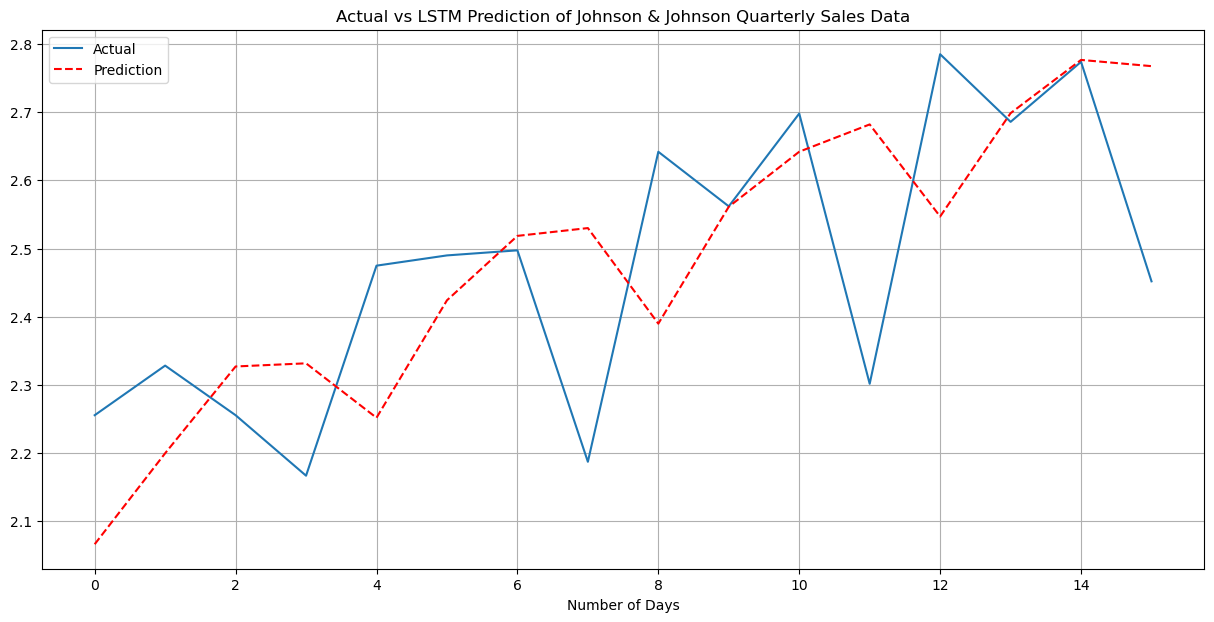

In [43]:
# plot actual and predicted data
plt.figure(figsize=(15,7))
plt.plot(log_data[-16:].values, label='Actual')
plt.plot(predictions_list[np.argmin(results)], 'r--', label='Prediction')
plt.xlabel('Number of Days')
plt.title('Actual vs LSTM Prediction of Johnson & Johnson Quarterly Sales Data')
plt.legend()
plt.grid()
plt.savefig('lstm_pred_jj.png', dpi=300, bbox_inches="tight")
plt.show()

## LSTM on Amazon data

In [49]:
# find best lambda
boxcox_amzn, lam = boxcox(amzn_data['Close'])
# print lambda
print(f'Lambda = {lam}')
# convert to Dataframe
boxcox_amzn = pd.DataFrame(boxcox_amzn)
# use the differencing operator
diff_boxcox_amzn = boxcox_amzn.diff().dropna()

Lambda = -0.36999985006271


In [53]:
# transform data to be supervised learning
supervised = transform_to_supervised(diff_boxcox_amzn, lookback=1)
supervised_values = supervised.values

In [54]:
# split data into train and test sets
train, test = supervised_values[0:-250], supervised_values[-250:]

In [56]:
# scale the data to -1 and 1
scaler, train_scaled, test_scaled = normalize_data(train, test)

In [63]:
# fit the model
lstm_model = build_lstm_model(train_scaled, batch_size_val=1, epochs_val=50,
                      num_neurons=4)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = predict_next_step(lstm_model, 1, X)
    # invert scaling
    yhat = reverse_normalization(scaler, X, yhat)
    # invert differencing
    yhat = reverse_differencing(boxcox_amzn.values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)

# report performance
rmse = np.sqrt(mean_squared_error(boxcox_amzn[-250:], predictions))
print('Test RMSE =', np.round(rmse, 3))

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test RMSE = 0.005


In [64]:
rmse

0.00538773973847809

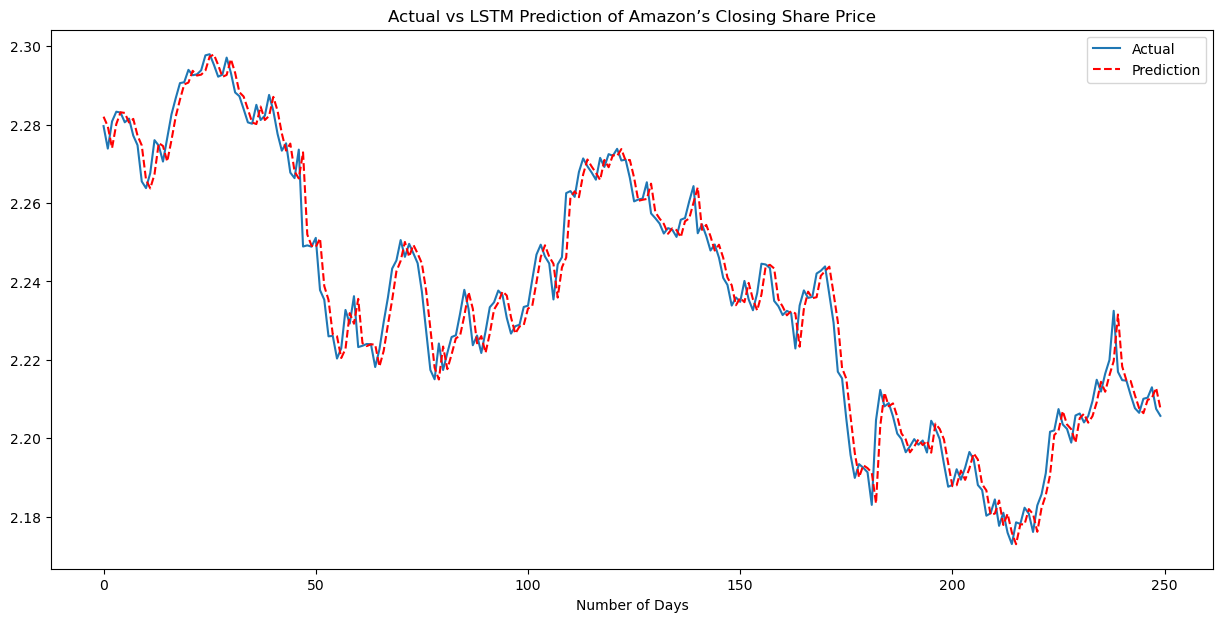

In [66]:
plt.figure(figsize=(15,7))
plt.plot(boxcox_amzn[-250:].values, label='Actual')
plt.plot(predictions, 'r--', label='Prediction')
plt.xlabel('Number of Days')
plt.title('Actual vs LSTM Prediction of Amazon’s Closing Share Price')
plt.legend()
plt.show()